In [2]:
# Install libraries before running:
# !pip install numpy pandas matplotlib seaborn scipy scikit-learn xgboost shap alepython

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryan9dai/XAI590_Ryan)

# XAI Assignment 4 
Ryan Dai

No external sources used, only https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb and ChatGPT 4o

In [3]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import seaborn as sns
from scipy.interpolate import RectBivariateSpline
from sklearn.base import is_classifier

# Dataset
from sklearn.datasets import load_iris

# Models
import xgboost as xgb
from sklearn.model_selection import train_test_split

# XAI
import shap
from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance

np.random.seed(1)

In [4]:
# Load dataset into dataframes
data = load_iris()

df = pd.DataFrame(data.data, columns=data.feature_names) # Full dataframe

df["target"] = data.target
y = pd.DataFrame(data.target, columns=["target"])  

X = df.drop(columns=["target"])
X = pd.DataFrame(data.data, columns=data.feature_names) 


print(df.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  


Pearson Correlation Matrix:
                    sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   

                   petal width (cm)  
sepal length (cm)          0.817941  
sepal width (cm)          -0.366126  
petal length (cm)          0.962865  
petal width (cm)           1.000000  
Spearman Correlation Matrix:
                    sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.166778           0.881898   
sepal width (cm)           -0.166778          1.000000          -0.309635   
petal length (cm)           0.881898         -0.309635           1.000000   
petal width (cm)            0.834289         -0.289032   

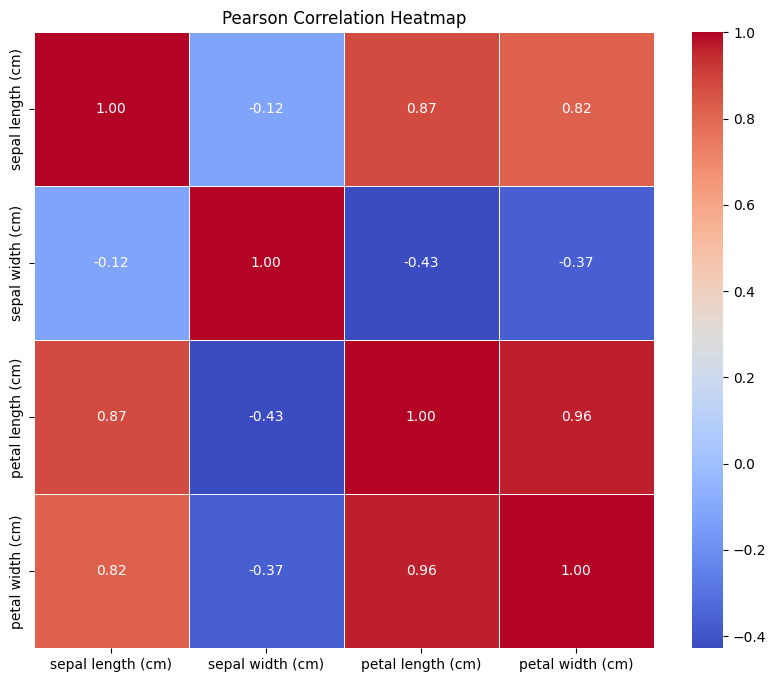

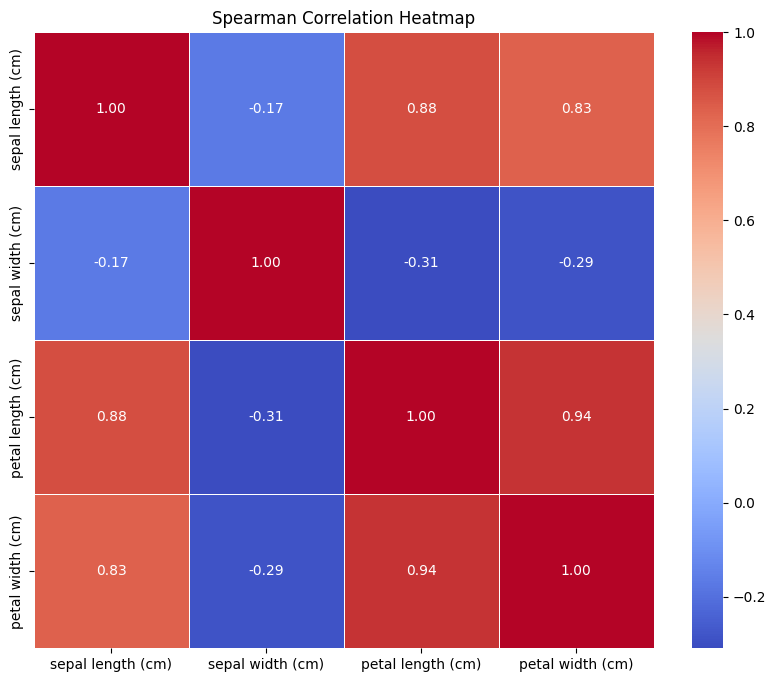

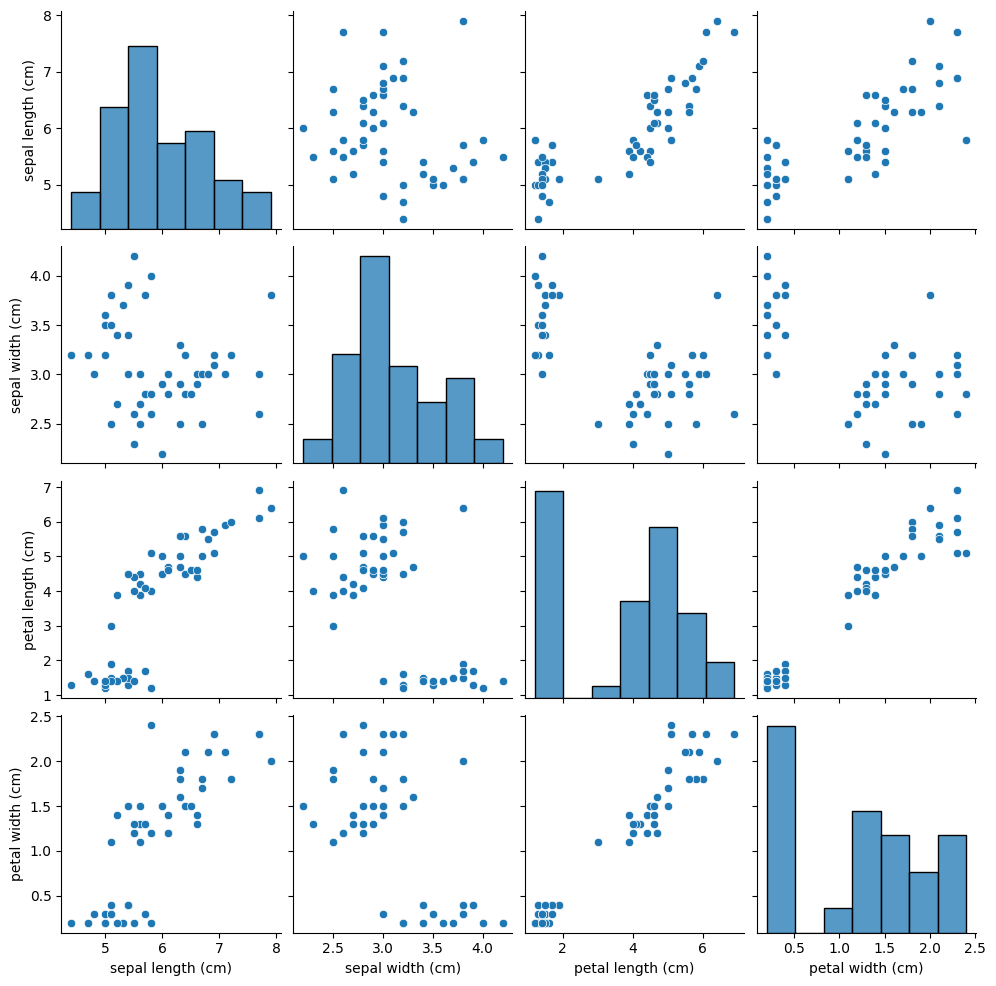

In [5]:
# EDA with simple code from ChatGPT 4o

# Pearson Correlation Matrix
pearson_corr = X.corr(method="pearson")
print("Pearson Correlation Matrix:\n", pearson_corr)

# Spearman Correlation Matrix
spearman_corr = X.corr(method="spearman")
print("Spearman Correlation Matrix:\n", spearman_corr)

# Visualizing Pearson Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Pearson Correlation Heatmap")
plt.show()

# Visualizing Spearman Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Spearman Correlation Heatmap")
plt.show()

# Pairplot to visualize relationships
sns.pairplot(X.sample(50))  # Sample 500 points for faster plotting
plt.show()

# Exploratory Data Analysis Discussion

There appears to be high correlation among and between all features, except sepal width, which does not correlate much with any other features. The Pearson, Spearman and pairplot graphs all show a similar result for all pairs. The pairplot reveals what looks to be a normal distribution for the features, but with a large number of small values, which may mean some very small flowers.

In [6]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Fit the XGBoost model

model = xgb.XGBClassifier().fit(X_train, y_train)

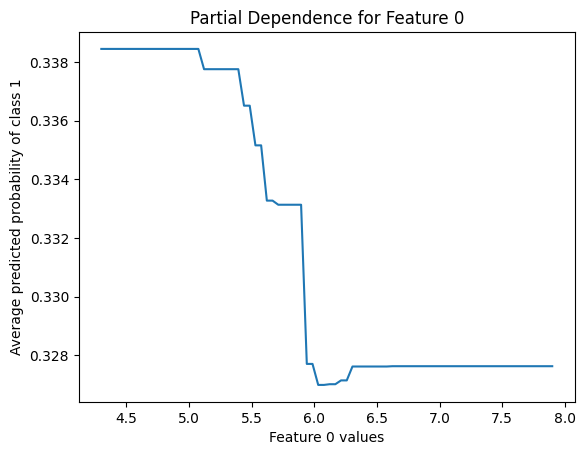

In [8]:
# PDP plot, numpy implementation from https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb

# Choose the feature for which you want to plot partial dependence
feature_index = 0  # For example, the first feature
target_class = 0

# Create feature grid - here is where you can update the size of the grid by updating num
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=80)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Duplicate the dataset to modify feature values
X_modified = X.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for all instances
    X_modified.iloc[:, feature_index] = value

    # Predict using the modified dataset
    predictions = model.predict_proba(X_modified)[:, target_class]

    # Calculate average prediction for the current feature value
    average_predictions[i] = np.mean(predictions)

# Plot the partial dependence for the chosen feature
plt.plot(feature_values, average_predictions)
plt.xlabel(f'Feature {feature_index} values')
plt.ylabel('Average predicted probability of class 1')
plt.title(f'Partial Dependence for Feature {feature_index}')
plt.show()

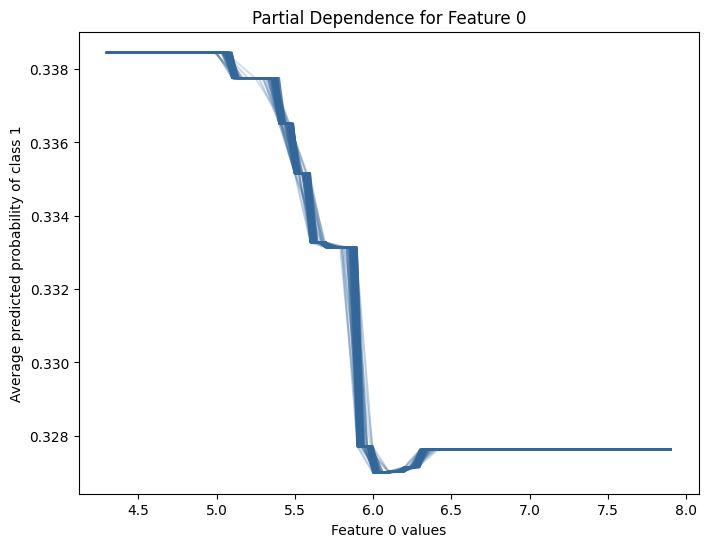

In [9]:
# ICE Plot, numpy implementation from https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb

grid_length = np.linspace(20, 120, 40)
fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and axis for plotting

# Define a base color and alpha (transparency) values
base_color = (0.2, 0.4, 0.6)  # Blue-ish color
min_alpha = 0.2
max_alpha = 1.0

# Normalize grid_length values between 0 and 1
normalized_g = (grid_length - grid_length.min()) / (grid_length.max() - grid_length.min())

for i, g in enumerate(grid_length):
    # Create feature grid
    feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=int(g))
    # Initialize array to store average predictions
    average_predictions = np.zeros_like(feature_values)
    # Duplicate the dataset to modify feature values
    X_modified = X.copy()
    # Loop over feature values
    for j, value in enumerate(feature_values):
        # Set the chosen feature to the current value for all instances
        X_modified.iloc[:, feature_index] = value
        # Predict using the modified dataset
        predictions = model.predict_proba(X_modified)[:, target_class]
        # Calculate average prediction for the current feature value
        average_predictions[j] = np.mean(predictions)
    # Calculate color based on normalized g
    alpha = min_alpha + (max_alpha - min_alpha) * normalized_g[i]
    color = to_rgba(base_color, alpha)
    # Plot the partial dependence for the chosen feature
    ax.plot(feature_values, average_predictions, color=color)

ax.set_xlabel(f'Feature {feature_index} values')
ax.set_ylabel('Average predicted probability of class 1')
ax.set_title(f'Partial Dependence for Feature {feature_index}')
plt.show()

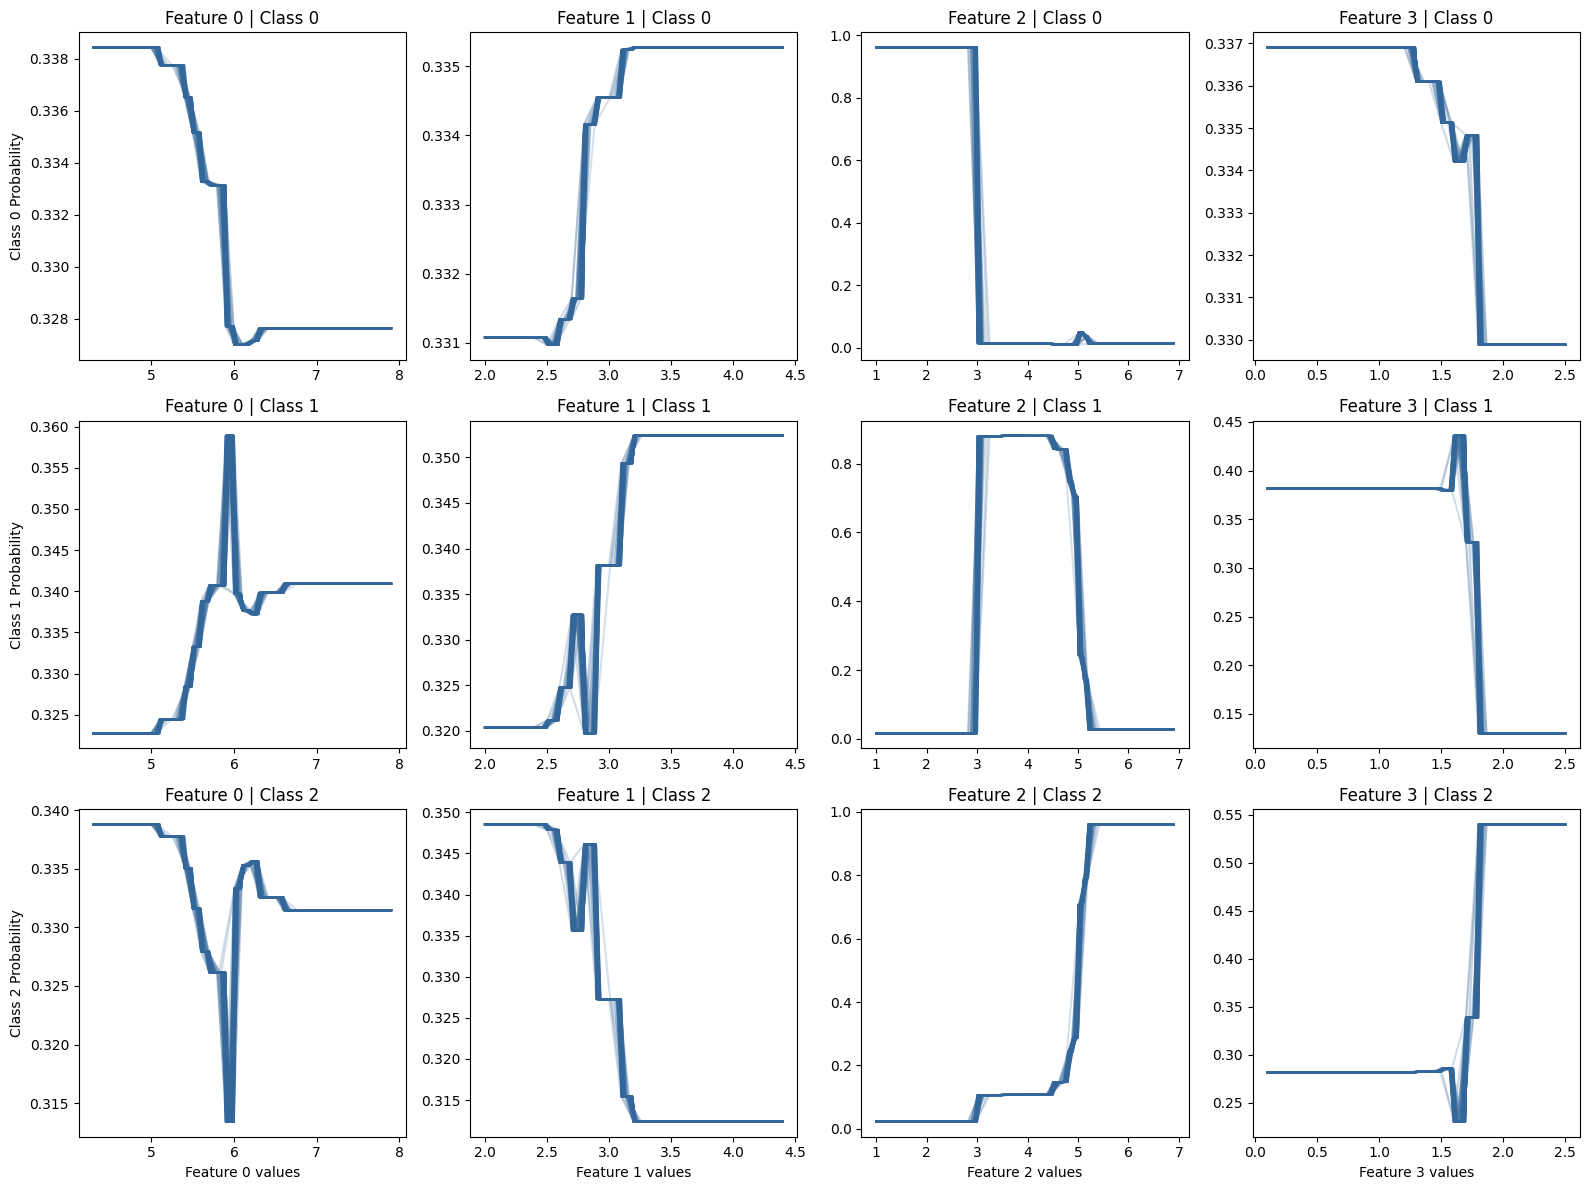

In [10]:
# Plot all possible ICE plots. Used ChatGPT 4o on 5 Feb 25 around 8:30pm ET to refactor the prior cell's code

# Feature indices (columns)
feature_indices = [0, 1, 2, 3]  # Sepal & Petal features
# Target class labels (rows)
target_classes = [0, 1, 2]  # Iris Setosa, Versicolor, Virginica

# Set up a grid of subplots (rows = target classes, columns = features)
fig, axes = plt.subplots(len(target_classes), len(feature_indices), figsize=(16, 12))

# Define a base color for ICE curves
base_color = (0.2, 0.4, 0.6)  # Blue-ish color
min_alpha = 0.2  # Minimum transparency
max_alpha = 1.0  # Maximum transparency

for row, target_class in enumerate(target_classes):  # Loop over classes (rows)
    for col, feature_index in enumerate(feature_indices):  # Loop over features (columns)
        ax = axes[row, col]  # Select subplot
        
        # Create feature grid
        grid_length = np.linspace(20, 120, 40)
        normalized_g = (grid_length - grid_length.min()) / (grid_length.max() - grid_length.min())  # Normalize
        
        for i, g in enumerate(grid_length):
            feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=int(g))
            average_predictions = np.zeros_like(feature_values)
            X_modified = X.copy()

            for j, value in enumerate(feature_values):
                X_modified.iloc[:, feature_index] = value
                predictions = model.predict_proba(X_modified)[:, target_class]
                average_predictions[j] = np.mean(predictions)

            alpha = min_alpha + (max_alpha - min_alpha) * normalized_g[i]
            color = to_rgba(base_color, alpha)
            ax.plot(feature_values, average_predictions, color=color)

        # Set labels and titles
        if row == len(target_classes) - 1:  # X-axis label only for bottom row
            ax.set_xlabel(f'Feature {feature_index} values')
        if col == 0:  # Y-axis label only for first column
            ax.set_ylabel(f'Class {target_class} Probability')

        ax.set_title(f'Feature {feature_index} | Class {target_class}')

# Adjust layout
plt.tight_layout()
plt.show()

# Analysis of ICE and PDP Plots 

The ICE and PDP Plots look similar, so we'll go over the ICE plots.

Most features do not affect the prediction much at their extreme values. It is usually small changes of the middle values that affect the prediction significantly.

Feature 0 sharply affects the prediction at a specific value of 6, making class 1 a slightly more likely prediction. Feature 1, when increasing, tends to reduce the chances of class 2 being predicted. However, both these features don't have a large effect when you look at the scale of the impact. Feature 2 can predict any class with high accuracy, with values betwen 1-3 corresponding to class 0, 3-5 for class 1 and 5-7 for class 2. Feature 3 can distinguish between classes 1 and 2 with a breakpoint at around 1.5. Essentially, features 2 and 3 predict the flower type with high accuracy, without much help from features 0 and 1, and they are also highly correlated (0.96 Pearson). It is possible that XGBoost prioritized feature 2 when feature 3 would equivalently give the same dependence plots in the absence of feature 2.

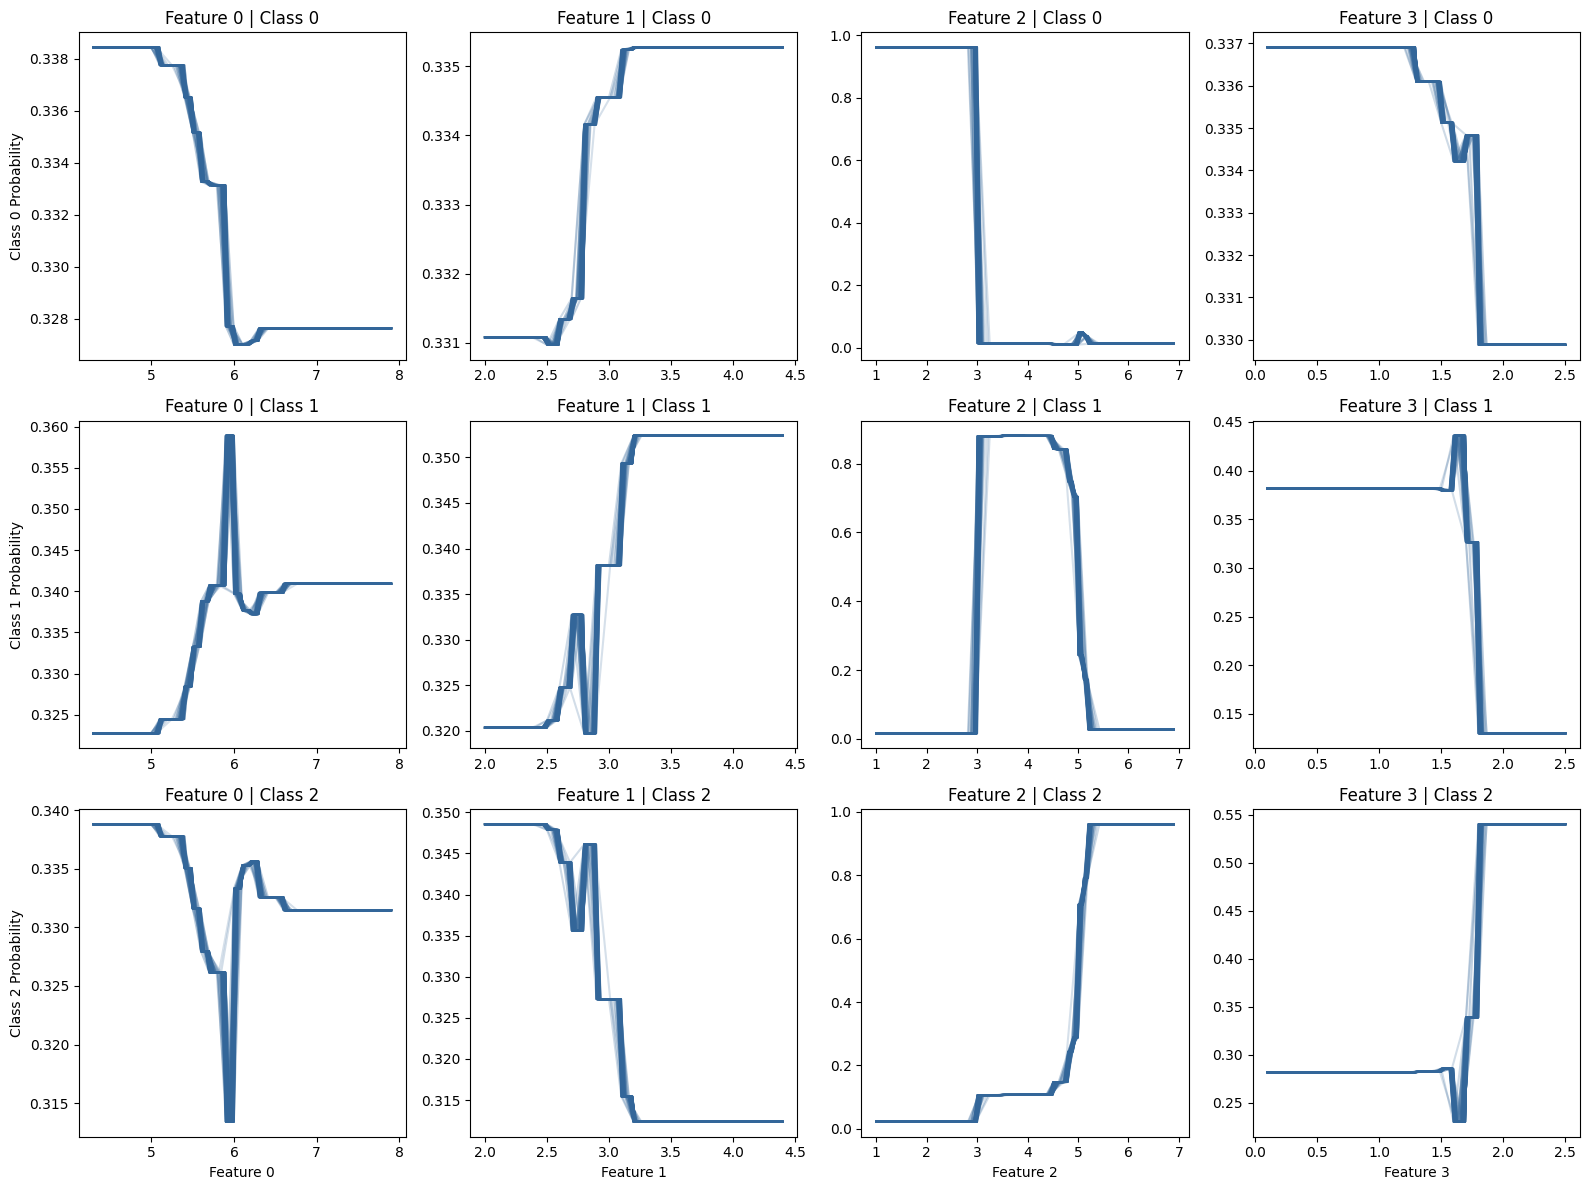

In [11]:
# Plots without feature 2

X_3f = X
X_3f.drop(columns=["petal length (cm)"])

X_3f_train, X_3f_test, y_3f_train, y_3f_test = train_test_split(X_3f, y, test_size=0.2, random_state=42)

model_3f = xgb.XGBClassifier().fit(X_3f_train, y_3f_train)

feature_indices = list(range(X_3f.shape[1]))
target_classes = [0, 1, 2]

fig, axes = plt.subplots(len(target_classes), len(feature_indices), figsize=(16, 12))

base_color = (0.2, 0.4, 0.6)
min_alpha, max_alpha = 0.2, 1.0

for row, target_class in enumerate(target_classes):
    for col, feature_index in enumerate(feature_indices):
        ax = axes[row, col]
        grid_length = np.linspace(20, 120, 40)
        normalized_g = (grid_length - grid_length.min()) / (grid_length.max() - grid_length.min())

        for i, g in enumerate(grid_length):
            feature_values = np.linspace(np.min(X_3f.iloc[:, feature_index]), np.max(X_3f.iloc[:, feature_index]), num=int(g))
            average_predictions = np.zeros_like(feature_values)
            X_modified = X_3f.copy()

            for j, value in enumerate(feature_values):
                X_modified.iloc[:, feature_index] = value
                predictions = model_3f.predict_proba(X_modified)[:, target_class]
                average_predictions[j] = np.mean(predictions)

            alpha = min_alpha + (max_alpha - min_alpha) * normalized_g[i]
            color = to_rgba(base_color, alpha)
            ax.plot(feature_values, average_predictions, color=color)

        if row == len(target_classes) - 1:
            ax.set_xlabel(f'Feature {feature_index}')
        if col == 0:
            ax.set_ylabel(f'Class {target_class} Probability')

        ax.set_title(f'Feature {feature_index} | Class {target_class}')

plt.tight_layout()
plt.show()

# Analysis of ICE Plots after Removal of Feature 2

Here, we see what I suggested is true. Feature 3 (above called Feature 2, but is the old Feature 3) can by itself predict the class with high probability.

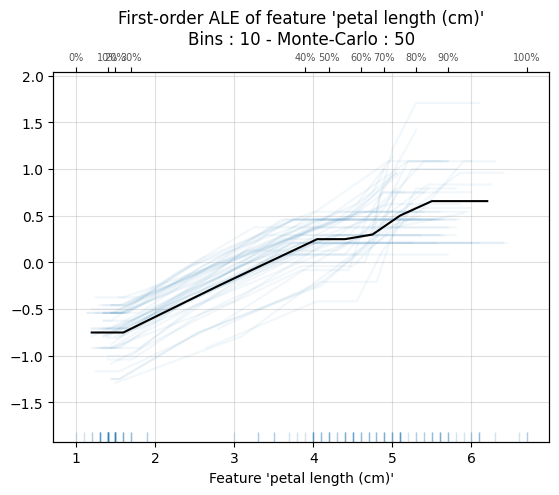

<Axes: title={'center': "First-order ALE of feature 'petal length (cm)'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'petal length (cm)'">

In [12]:
# 1D ALE Plots from https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb

ale_plot(model, X_train, 'petal length (cm)', monte_carlo=True)

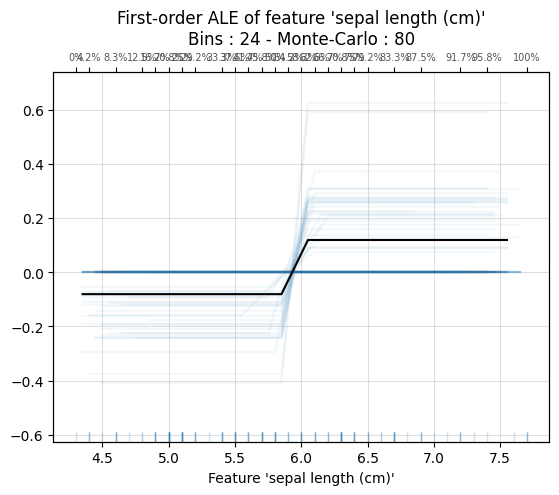

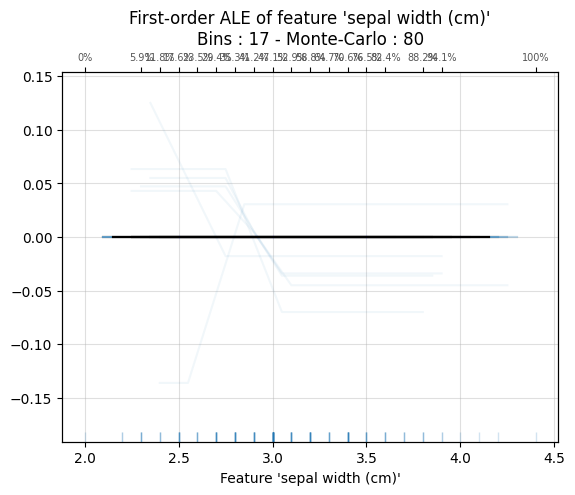

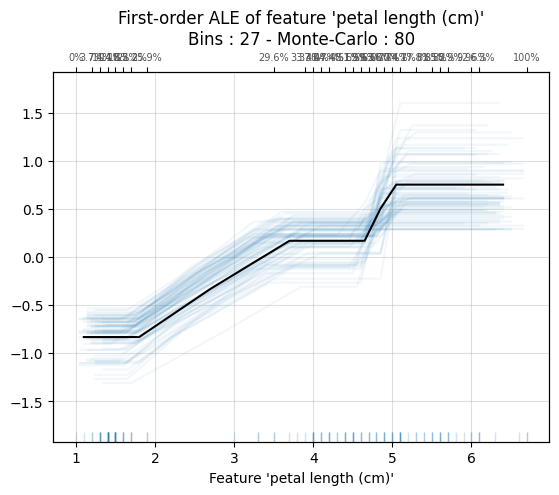

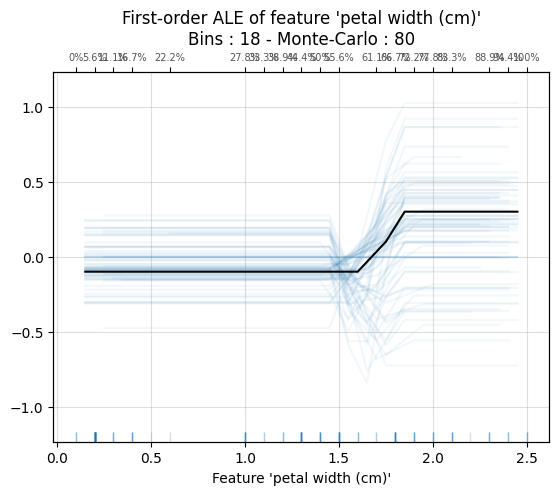

<Axes: title={'center': "First-order ALE of feature 'petal width (cm)'\nBins : 18 - Monte-Carlo : 80"}, xlabel="Feature 'petal width (cm)'">

In [13]:
# 1D ALE Plots from https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb

ale_plot(
    model,
    X_train,
    'sepal length (cm)',
    bins=30,
    monte_carlo=True,
    monte_carlo_rep=80,
    monte_carlo_ratio=0.5,
)

ale_plot(
    model,
    X_train,
    'sepal width (cm)',
    bins=30,
    monte_carlo=True,
    monte_carlo_rep=80,
    monte_carlo_ratio=0.5,
)

ale_plot(
    model,
    X_train,
    'petal length (cm)',
    bins=30,
    monte_carlo=True,
    monte_carlo_rep=80,
    monte_carlo_ratio=0.5,
)

ale_plot(
    model,
    X_train,
    'petal width (cm)',
    bins=30,
    monte_carlo=True,
    monte_carlo_rep=80,
    monte_carlo_ratio=0.5,
)

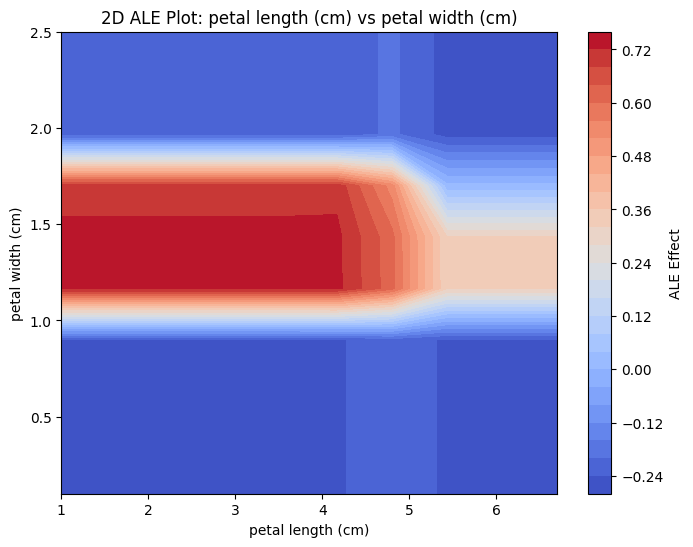

In [14]:
# 2D ALE plot. Non-library ALE plot code fully generated by ChatGPT 4o on Feb 5 around 8pm ET. 

def ale_2d(model, X, feature_indices=(0, 1), bins=10):
    """
    Compute a 2D ALE plot for two features.

    Parameters:
    - model: Trained machine learning model
    - X: Feature dataset (pandas DataFrame)
    - feature_indices: Tuple (feature_1_index, feature_2_index)
    - bins: Number of bins per feature

    Returns:
    - 2D ALE effect plot
    """

    # Extract feature names and values
    f1, f2 = feature_indices
    feature_1, feature_2 = X.columns[f1], X.columns[f2]

    # Create feature grids
    f1_grid = np.linspace(X.iloc[:, f1].min(), X.iloc[:, f1].max(), bins)
    f2_grid = np.linspace(X.iloc[:, f2].min(), X.iloc[:, f2].max(), bins)

    # Store ALE values
    ale_values = np.zeros((bins, bins))

    # Create a copy of X
    X_modified = X.copy()

    # Compute ALE for each grid point
    for i, v1 in enumerate(f1_grid):
        for j, v2 in enumerate(f2_grid):
            X_modified.iloc[:, f1] = v1
            X_modified.iloc[:, f2] = v2

            # Predict probabilities if it's a classifier, else predict normally
            if hasattr(model, "predict_proba"):  # FIXED: Instead of is_classifier()
                pred = model.predict_proba(X_modified)[:, 1]  # Change class index if needed
            else:
                pred = model.predict(X_modified)

            ale_values[i, j] = np.mean(pred)

    # Normalize ALE values (center around zero)
    ale_values -= ale_values.mean()

    # Interpolation for smoothness
    interp = RectBivariateSpline(f1_grid, f2_grid, ale_values)

    # Create meshgrid for plotting
    f1_mesh, f2_mesh = np.meshgrid(f1_grid, f2_grid)
    ale_smooth = interp(f1_grid, f2_grid)

    # Plot the ALE effect as a contour plot
    plt.figure(figsize=(8, 6))
    plt.contourf(f1_mesh, f2_mesh, ale_smooth, cmap="coolwarm", levels=30)
    plt.colorbar(label="ALE Effect")
    plt.xlabel(feature_1)
    plt.ylabel(feature_2)
    plt.title(f"2D ALE Plot: {feature_1} vs {feature_2}")
    plt.show()

# Example usage
ale_2d(model, X_train, feature_indices=(2, 3), bins=10)

# ALE Plot Analysis

'sepal length (cm)' = Feature 0
'sepal width (cm)'  = Feature 1
'petal length (cm)' = Feature 2
'petal width (cm)'  = Feature 3
We can see that the 1D ALE plots show what we expected from the ICE plots. Feature 0 has a small effect, and Feature 1 has no effect on the result. Feature 2 has a very large effect on the result, and Feature 3 has a moderate effect.

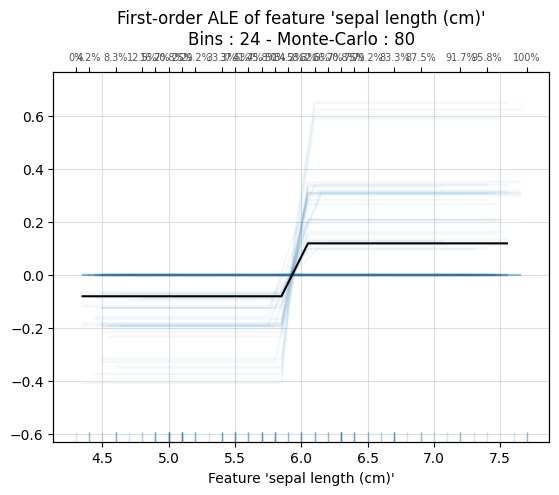

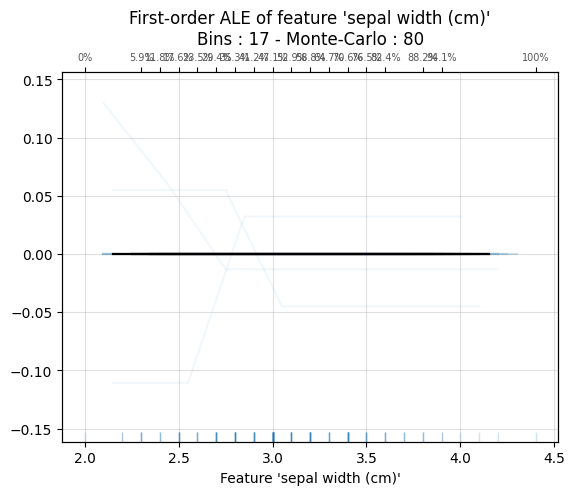

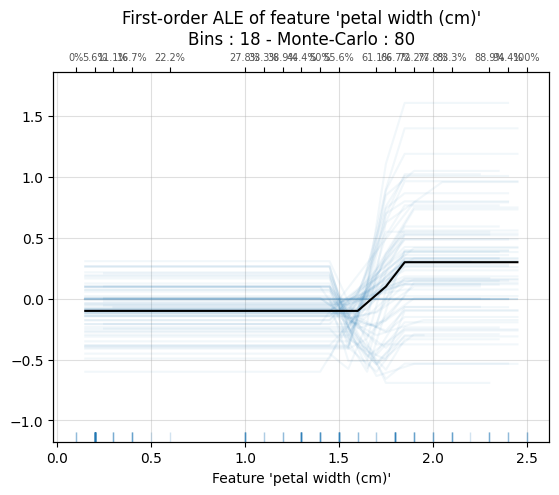

<Axes: title={'center': "First-order ALE of feature 'petal width (cm)'\nBins : 18 - Monte-Carlo : 80"}, xlabel="Feature 'petal width (cm)'">

In [15]:
# 1D ALE Plots from https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/global_explanations.ipynb

ale_plot(
    model_3f,
    X_3f_train,
    'sepal length (cm)',
    bins=30,
    monte_carlo=True,
    monte_carlo_rep=80,
    monte_carlo_ratio=0.5,
)

ale_plot(
    model_3f,
    X_3f_train,
    'sepal width (cm)',
    bins=30,
    monte_carlo=True,
    monte_carlo_rep=80,
    monte_carlo_ratio=0.5,
)

ale_plot(
    model_3f,
    X_3f_train,
    'petal width (cm)',
    bins=30,
    monte_carlo=True,
    monte_carlo_rep=80,
    monte_carlo_ratio=0.5,
)

# ALE Plot Analysis Cont.

Unlike the experiment with ICE plots where we removed Feature 2 and observed Feature 3 having a larger impact, in the ALE plot this is not the case. Perhaps it is not as strong a predictor in general, but is much more impactful than Feature 0 so it is still main predictor without Feature 2. This is supported by the 2D ALE plot, which shows that Feature 2 has a strong predictive effect for all values, if Feature 3 is within the range 1-2.